# Wav2Vec2 transfer learning on wav2vec2-base

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import torch
import random
from torch.utils.data import Dataset
from transformers import Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


## Load Dataset

In [ ]:
df_train = pd.read_csv('../data/train_dataset.csv')
df_train = df_train[['Filepath', 'Emotion']]
df_test = pd.read_csv('../data/test_dataset.csv')
df_test = df_test[['Filepath', 'Emotion']]

In [4]:
print(df_train)
print(df_test)

                                                Filepath   Emotion
0              ./dataset/mlend\MLEndSND_Public\12243.wav   Neutral
1         ./dataset/crema-d\AudioWAV\1075_ITH_NEU_XX.wav   Neutral
2         ./dataset/crema-d\AudioWAV\1050_TIE_NEU_XX.wav   Neutral
3              ./dataset/mlend\MLEndSND_Public\10530.wav     Happy
4         ./dataset/crema-d\AudioWAV\1001_IEO_FEA_LO.wav      Fear
...                                                  ...       ...
50534                ./dataset/meld\train\dia23_utt7.mp4   Neutral
50535          ./dataset/tess\YAF_fear\YAF_read_fear.wav      Fear
50536          ./dataset/mlend\MLEndSND_Public\22283.wav     Happy
50537          ./dataset/mlend\MLEndSND_Public\02938.wav  Question
50538  ./dataset/ravdess\Actor_11\03-01-06-01-01-01-1...      Fear

[50539 rows x 2 columns]
                                                Filepath   Emotion
0            ./dataset/esd\0017\Surprise\0017_001602.wav  Surprise
1              ./dataset/mlend\MLEnd

In [5]:
# Convert labels to integers
unique_labels = sorted(df_train['Emotion'].unique())  
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print(label_map)

df_train['Emotion'] = df_train['Emotion'].map(label_map)
df_test['Emotion'] = df_test['Emotion'].map(label_map)

{'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}


In [6]:
print(df_train)
print(df_test)

                                                Filepath  Emotion
0              ./dataset/mlend\MLEndSND_Public\12243.wav        5
1         ./dataset/crema-d\AudioWAV\1075_ITH_NEU_XX.wav        5
2         ./dataset/crema-d\AudioWAV\1050_TIE_NEU_XX.wav        5
3              ./dataset/mlend\MLEndSND_Public\10530.wav        4
4         ./dataset/crema-d\AudioWAV\1001_IEO_FEA_LO.wav        3
...                                                  ...      ...
50534                ./dataset/meld\train\dia23_utt7.mp4        5
50535          ./dataset/tess\YAF_fear\YAF_read_fear.wav        3
50536          ./dataset/mlend\MLEndSND_Public\22283.wav        4
50537          ./dataset/mlend\MLEndSND_Public\02938.wav        6
50538  ./dataset/ravdess\Actor_11\03-01-06-01-01-01-1...        3

[50539 rows x 2 columns]
                                                Filepath  Emotion
0            ./dataset/esd\0017\Surprise\0017_001602.wav        8
1              ./dataset/mlend\MLEndSND_Public\018

In [7]:
# Custom dataset class
class SpeechEmotionDataset(Dataset):
    # Max_length = 4s, 64000 because sampling rate is 16000
    def __init__(self, df, processor, max_length=64000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = '../data/' + self.df.iloc[idx]['Filepath']
        label = self.df.iloc[idx]['Emotion']
        
        # Load audio file
        speech, sr = librosa.load(audio_path, sr=16000)
        
        # Pad speech to required length
        speech = np.pad(speech, (0, self.max_length - len(speech)), mode='constant')
        
        # Preprocess audio
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)
        
        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [8]:
model_name = 'facebook/wav2vec2-base'
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\transformers\configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Load the dataset
train_dataset = SpeechEmotionDataset(df_train, processor)
test_dataset = SpeechEmotionDataset(df_test, processor)

In [10]:
train_dataset[0]

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


{'input_values': tensor([-0.0078,  0.0006,  0.0134,  ...,  0.0013,  0.0013,  0.0013]),
 'labels': tensor(5)}

## Set Training Arguments

In [ ]:
train_args = TrainingArguments(
    output_dir='./models/wav2vec2-base',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[]
)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Create function for computing metrics
def compute_metrics(pred):
    labels = pred.label_ids # original labels
    preds = np.argmax(pred.predictions, axis=1) # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision, 
        "recall": recall,
        "f1": f1
    }

In [13]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [14]:
trainer.train()

C:\Users\profi\AppData\Local\Temp\ipykernel_23872\1804329444.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sr = librosa.load(audio_path, sr=16000)
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.629700,0.576559,0.804036,0.824674,0.804036,0.804312
2,0.449400,0.442646,0.852315,0.857739,0.852315,0.852253
3,0.331100,0.424579,0.865374,0.868143,0.865374,0.865004


C:\Users\profi\AppData\Local\Temp\ipykernel_23872\1804329444.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sr = librosa.load(audio_path, sr=16000)
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\profi\AppData\Local\Temp\ipykernel_23872\1804329444.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sr = librosa.load(audio_path, sr=16000)
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype

TrainOutput(global_step=9477, training_loss=0.5784893351868133, metrics={'train_runtime': 3108.9778, 'train_samples_per_second': 48.767, 'train_steps_per_second': 3.048, 'total_flos': 5.506004919364992e+18, 'train_loss': 0.5784893351868133, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

## Test Predictions

C:\Users\profi\AppData\Local\Temp\ipykernel_23872\1804329444.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, sr = librosa.load(audio_path, sr=16000)
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


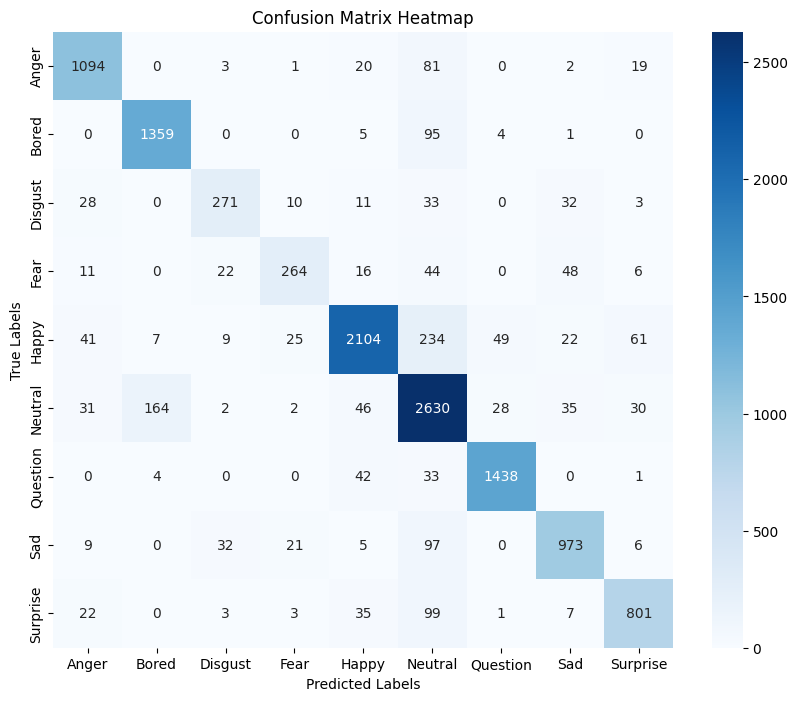

In [45]:
# Get model predictions on the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Convert logits to predicted class labels
true_labels = predictions.label_ids  # Ground truth labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [46]:
inv_label_map = {idx: label for label, idx in label_map.items()}
print(inv_label_map)

{0: 'Anger', 1: 'Bored', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Question', 7: 'Sad', 8: 'Surprise'}


In [47]:
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inv_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label:', inv_label_map[predicted_class])

Original Label: Happy
Predicted Label: Happy


In [50]:
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inv_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label:', inv_label_map[predicted_class])

Original Label: Anger
Predicted Label: Anger


In [51]:
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inv_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label:', inv_label_map[predicted_class])

Original Label: Anger
Predicted Label: Anger
